车牌定位
1. 原始图片


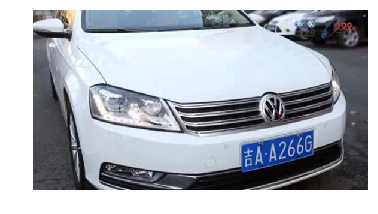

2. 高斯去噪


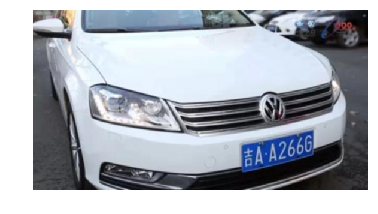

3. 去除不是车牌的区域
3.1 开运算：先腐蚀后膨胀，消除小物体


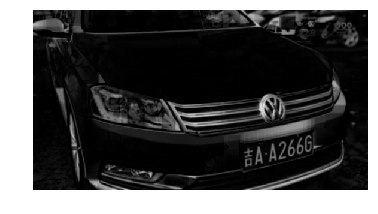

3.2 二值化


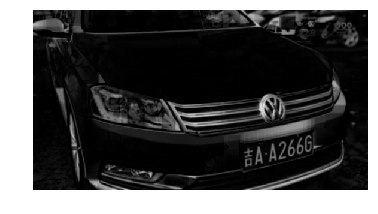

3.3 canny找边缘


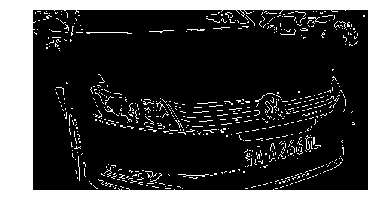

3.4 开运算和闭运算让图像边缘成为一个整体


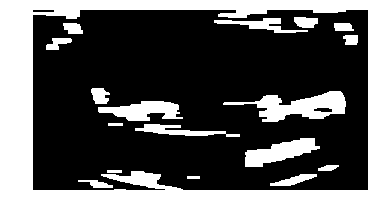

3.5.1 查找图像边缘整体形成的矩形区域: len(contours) 3
3.5.1 矩形标注


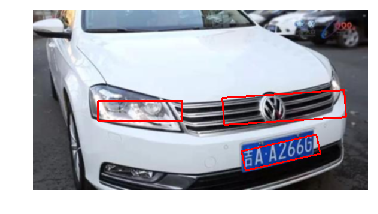

3.5.2 排除不是车牌的矩形区域: len(car_contours) 3
4. 精确定位 !颜色设置需要调整，对于暗色的图片预测结果不理想
blue
3709 1 2 80 0 5106
no
509 0 0 4 93 5548
no
1642 13 0 2529 54 10650
字符识别
======可能车牌 No.0
1. 二值化


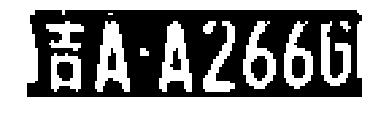

2. 字符 No.0


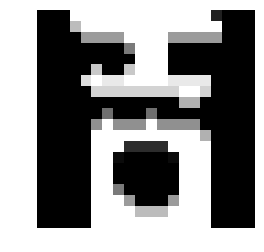

2. 字符 No.1


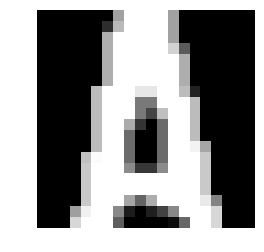

2. 字符 No.2


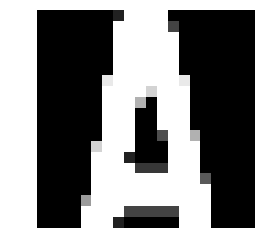

2. 字符 No.3


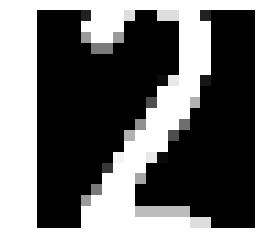

2. 字符 No.4


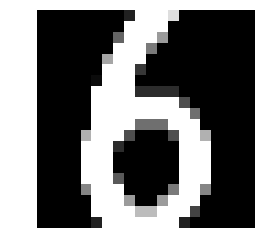

2. 字符 No.5


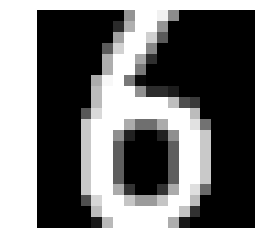

2. 字符 No.6


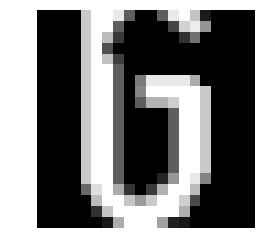

['晋', 'A', 'A', '2', '6', '6', 'G']


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import json

from train_ocr import *


def cv_ipy_imshow(cv_image, color="bgr", title=None, title_fs=20):
    if color == "bgr":
        img = cv.cvtColor(cv_image,cv.COLOR_BGR2RGB)
    elif color == "gray":
        img = cv.cvtColor(cv_image,cv.COLOR_GRAY2RGB)
    
    if type(title) == type(""):
        is_ascii = True
        for c in title:
            if ord(c) > 128:
                is_ascii = False
                break
        if is_ascii:
            plt.title(title, fontsize=title_fs)
        else:
            print(title)
    plt.imshow(img)
    plt.axis("off")
    plt.show()


# https://github.com/wzh191920/License-Plate-Recognition/blob/master/predict.py

SZ = 20          #训练图片长宽
MAX_WIDTH = 1000 #原始图片最大宽度
Min_Area = 2000  #车牌区域允许最大面积


def point_limit(point):
    if point[0] < 0:
        point[0] = 0
    if point[1] < 0:
        point[1] = 0

#根据设定的阈值和图片直方图，找出波峰，用于分隔字符
def find_waves(threshold, histogram):
    up_point = -1#上升点
    is_peak = False
    if histogram[0] > threshold:
        up_point = 0
        is_peak = True
    wave_peaks = []
    for i,x in enumerate(histogram):
        if is_peak and x < threshold:
            if i - up_point > 2:
                is_peak = False
                wave_peaks.append((up_point, i))
        elif not is_peak and x >= threshold:
            is_peak = True
            up_point = i
    if is_peak and up_point != -1 and i - up_point > 4:
        wave_peaks.append((up_point, i))
    return wave_peaks

#根据找出的波峰，分隔图片，从而得到逐个字符图片
def seperate_card(img, waves):
    part_cards = []
    for wave in waves:
        part_cards.append(img[:, wave[0]:wave[1]])
    return part_cards


provinces = [
    "zh_cuan", "川", "zh_e", "鄂", "zh_gan", "赣", "zh_gan1", "甘", "zh_gui", "贵", 
    "zh_gui1", "桂", "zh_hei", "黑", "zh_hu", "沪", "zh_ji", "冀", "zh_jin", "津", 
    "zh_jing", "京", "zh_jl", "吉", "zh_liao", "辽", "zh_lu", "鲁", "zh_meng", "蒙", 
    "zh_min", "闽", "zh_ning", "宁", "zh_qing", "靑", "zh_qiong", "琼", "zh_shan", "陕",
    "zh_su", "苏", "zh_sx", "晋", "zh_wan", "皖", "zh_xiang", "湘", "zh_xin", "新",
    "zh_yu", "豫", "zh_yu1", "渝", "zh_yue", "粤", "zh_yun", "云", "zh_zang", "藏", "zh_zhe", "浙"
]



class PlateRecog(object):
    def __init__(self):
        self.model_char = SVM()
        self.model_chi = SVM()
        self.model_char.load("chars2.dat")
        self.model_chi.load("charsChinese.dat")
        self._config = {
            "blur" : 3,
            "morphologyr" : 4,
            "morphologyc" : 19,
            "col_num_limit" : 10,
            "row_num_limit" : 21
        }

    @property
    def config(self):
        return self._config

    @config.setter
    def config(self, config):
        self._config = config

    def accurate_place(self, card_img_hsv, limit1, limit2, color):
        row_num, col_num = card_img_hsv.shape[:2]
        xl, xr = col_num, 0
        yh, yl = 0, row_num
        #col_num_limit = self._config["col_num_limit"]
        row_num_limit = self._config["row_num_limit"]
        col_num_limit = col_num * 0.8 if color != "green" else col_num * 0.5#绿色有渐变
        for i in range(row_num):
            count = 0
            for j in range(col_num):
                H = card_img_hsv.item(i, j, 0)
                S = card_img_hsv.item(i, j, 1)
                V = card_img_hsv.item(i, j, 2)
                if limit1 < H <= limit2 and 34 < S and 46 < V:
                    count += 1
            if count > col_num_limit:
                if yl > i:
                    yl = i
                if yh < i:
                    yh = i
        for j in range(col_num):
            count = 0
            for i in range(row_num):
                H = card_img_hsv.item(i, j, 0)
                S = card_img_hsv.item(i, j, 1)
                V = card_img_hsv.item(i, j, 2)
                if limit1 < H <= limit2 and 34 < S and 46 < V:
                    count += 1
            if count > row_num - row_num_limit:
                if xl > j:
                    xl = j
                if xr < j:
                    xr = j
        return xl, xr, yh, yl
        
    def predict(self, car_pic):
        if type(car_pic) == type(""):
            img = cv.imdecode(np.fromfile(car_pic, dtype=np.uint8), cv.IMREAD_COLOR)
        else:
            img = car_pic

        pic_hight, pic_width = img.shape[:2]
        if pic_width > MAX_WIDTH:
            resize_rate = MAX_WIDTH / pic_width
            img = cv.resize(img, (MAX_WIDTH, int(pic_hight*resize_rate)), interpolation=cv.INTER_AREA)
        
        ####################
        print("====================\n车牌定位\n====================")
        cv_ipy_imshow(img, title="1. 原始图片")
        blur = self._config["blur"]
        #高斯去噪
        if blur > 0:
            img = cv.GaussianBlur(img, (blur, blur), 0)#图片分辨率调整
        oldimg = img
        ####################
        cv_ipy_imshow(img, title="2. 高斯去噪")
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        #equ = cv.equalizeHist(img)
        #img = np.hstack((img, equ))
        #去掉图像中不会是车牌的区域
        ####################
        print("3. 去除不是车牌的区域")
        kernel = np.ones((20, 20), np.uint8)
        img_opening = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
        img_opening = cv.addWeighted(img, 1, img_opening, -1, 0);
        cv_ipy_imshow(img_opening, color="gray", title="3.1 开运算：先腐蚀后膨胀，消除小物体")

        #找到图像边缘
        ret, img_thresh = cv.threshold(img_opening, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
        ####################
        cv_ipy_imshow(img_opening, color="gray", title="3.2 二值化")
        img_edge = cv.Canny(img_thresh, 100, 200)
        ####################
        cv_ipy_imshow(img_edge, color="gray", title="3.3 canny找边缘")
        #使用开运算和闭运算让图像边缘成为一个整体
        kernel = np.ones((self._config["morphologyr"], self._config["morphologyc"]), np.uint8)
        img_edge1 = cv.morphologyEx(img_edge, cv.MORPH_CLOSE, kernel)
        img_edge2 = cv.morphologyEx(img_edge1, cv.MORPH_OPEN, kernel)
        ####################
        cv_ipy_imshow(img_edge2, color="gray", title="3.4 开运算和闭运算让图像边缘成为一个整体")

        #查找图像边缘整体形成的矩形区域，可能有很多，车牌就在其中一个矩形区域中
        image, contours, hierarchy = cv.findContours(img_edge2, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        contours = [cnt for cnt in contours if cv.contourArea(cnt) > Min_Area]
        print('3.5.1 查找图像边缘整体形成的矩形区域: len(contours)', len(contours))
        #一一排除不是车牌的矩形区域
        car_contours = []
        for cnt in contours:
            rect = cv.minAreaRect(cnt)
            area_width, area_height = rect[1]
            if area_width < area_height:
                area_width, area_height = area_height, area_width
            wh_ratio = area_width / area_height
            #print(wh_ratio)
            #要求矩形区域长宽比在2到5.5之间，2到5.5是车牌的长宽比，其余的矩形排除
            if wh_ratio > 2 and wh_ratio < 5.5:
                car_contours.append(rect)
                box = cv.boxPoints(rect)
                box = np.int0(box)
                ####################
                oldimg = cv.drawContours(oldimg, [box], 0, (0, 0, 255), 2)
                #cv.imshow("edge4", oldimg)
                #print(rect)
        ####################
        cv_ipy_imshow(oldimg, title="3.5.1 矩形标注")

        print('3.5.2 排除不是车牌的矩形区域: len(car_contours)', len(car_contours))

        print("4. 精确定位 !颜色设置需要调整，对于暗色的图片预测结果不理想")
        card_imgs = []
        #矩形区域可能是倾斜的矩形，需要矫正，以便使用颜色定位
        for rect in car_contours:
            if rect[2] > -1 and rect[2] < 1:#创造角度，使得左、高、右、低拿到正确的值
                angle = 1
            else:
                angle = rect[2]
            rect = (rect[0], (rect[1][0]+5, rect[1][1]+5), angle)#扩大范围，避免车牌边缘被排除

            box = cv.boxPoints(rect)
            heigth_point = right_point = [0, 0]
            left_point = low_point = [pic_width, pic_hight]
            for point in box:
                if left_point[0] > point[0]:
                    left_point = point
                if low_point[1] > point[1]:
                    low_point = point
                if heigth_point[1] < point[1]:
                    heigth_point = point
                if right_point[0] < point[0]:
                    right_point = point

            if left_point[1] <= right_point[1]:#正角度
                new_right_point = [right_point[0], heigth_point[1]]
                pts2 = np.float32([left_point, heigth_point, new_right_point])#字符只是高度需要改变
                pts1 = np.float32([left_point, heigth_point, right_point])
                M = cv.getAffineTransform(pts1, pts2)
                dst = cv.warpAffine(oldimg, M, (pic_width, pic_hight))
                point_limit(new_right_point)
                point_limit(heigth_point)
                point_limit(left_point)
                card_img = dst[int(left_point[1]):int(heigth_point[1]), int(left_point[0]):int(new_right_point[0])]
                card_imgs.append(card_img)
                #cv.imshow("card", card_img)
                #cv.waitKey(0)
            elif left_point[1] > right_point[1]:#负角度
                
                new_left_point = [left_point[0], heigth_point[1]]
                pts2 = np.float32([new_left_point, heigth_point, right_point])#字符只是高度需要改变
                pts1 = np.float32([left_point, heigth_point, right_point])
                M = cv.getAffineTransform(pts1, pts2)
                dst = cv.warpAffine(oldimg, M, (pic_width, pic_hight))
                point_limit(right_point)
                point_limit(heigth_point)
                point_limit(new_left_point)
                card_img = dst[int(right_point[1]):int(heigth_point[1]), int(new_left_point[0]):int(right_point[0])]
                card_imgs.append(card_img)
                #cv.imshow("card", card_img)
                #cv.waitKey(0)
        #开始使用颜色定位，排除不是车牌的矩形，目前只识别蓝、绿、黄车牌
        colors = []
        for card_index,card_img in enumerate(card_imgs):
            green = yello = blue = black = white = 0
            card_img_hsv = cv.cvtColor(card_img, cv.COLOR_BGR2HSV)
            #有转换失败的可能，原因来自于上面矫正矩形出错
            if card_img_hsv is None:
                continue
            row_num, col_num= card_img_hsv.shape[:2]
            card_img_count = row_num * col_num

            for i in range(row_num):
                for j in range(col_num):
                    H = card_img_hsv.item(i, j, 0)
                    S = card_img_hsv.item(i, j, 1)
                    V = card_img_hsv.item(i, j, 2)
                    if 11 < H <= 34 and S > 34:#图片分辨率调整
                        yello += 1
                    elif 35 < H <= 99 and S > 34:#图片分辨率调整
                        green += 1
                    elif 99 < H <= 124 and S > 34:#图片分辨率调整
                        blue += 1
                    
                    if 0 < H <180 and 0 < S < 255 and 0 < V < 46:
                        black += 1
                    elif 0 < H <180 and 0 < S < 43 and 221 < V < 225:
                        white += 1
            color = "no"

            limit1 = limit2 = 0
            if yello*2 >= card_img_count:
                color = "yello"
                limit1 = 11
                limit2 = 34#有的图片有色偏偏绿
            elif green*2 >= card_img_count:
                color = "green"
                limit1 = 35
                limit2 = 99
            elif blue*3 >= card_img_count:  ### 图像有的偏暗
                color = "blue"
                limit1 = 100
                limit2 = 124#有的图片有色偏偏紫
            elif black + white >= card_img_count*0.7:#TODO
                color = "bw"
            print(color)
            colors.append(color)
            print(blue, green, yello, black, white, card_img_count)
            #cv.imshow("color", card_img)
            #cv.waitKey(0)
            if limit1 == 0:
                continue
            #以上为确定车牌颜色
            #以下为根据车牌颜色再定位，缩小边缘非车牌边界
            xl, xr, yh, yl = self.accurate_place(card_img_hsv, limit1, limit2, color)
            if yl == yh and xl == xr:
                continue
            need_accurate = False
            if yl >= yh:
                yl = 0
                yh = row_num
                need_accurate = True
            if xl >= xr:
                xl = 0
                xr = col_num
                need_accurate = True
            card_imgs[card_index] = card_img[yl:yh, xl:xr] if color != "green" or yl < (yh-yl)//4 else card_img[yl-(yh-yl)//4:yh, xl:xr]
            if need_accurate:#可能x或y方向未缩小，需要再试一次
                card_img = card_imgs[card_index]
                card_img_hsv = cv.cvtColor(card_img, cv.COLOR_BGR2HSV)
                xl, xr, yh, yl = self.accurate_place(card_img_hsv, limit1, limit2, color)
                if yl == yh and xl == xr:
                    continue
                if yl >= yh:
                    yl = 0
                    yh = row_num
                if xl >= xr:
                    xl = 0
                    xr = col_num
            card_imgs[card_index] = card_img[yl:yh, xl:xr] if color != "green" or yl < (yh-yl)//4 else card_img[yl-(yh-yl)//4:yh, xl:xr]
        #以上为车牌定位
        #以下为识别车牌中的字符
        print("====================\n字符识别\n====================")
        predict_result = []
        roi = None
        card_color = None
        for i, color in enumerate(colors):
            if color in ("blue", "yello", "green"):
                print("======可能车牌 No."+str(i))
                card_img = card_imgs[i]
                gray_img = cv.cvtColor(card_img, cv.COLOR_BGR2GRAY)
                #黄、绿车牌字符比背景暗、与蓝车牌刚好相反，所以黄、绿车牌需要反向
                if color == "green" or color == "yello":
                    gray_img = cv.bitwise_not(gray_img)
                ret, gray_img = cv.threshold(gray_img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
                ####################
                cv_ipy_imshow(gray_img, color="gray", title="1. 二值化")
                #查找水平直方图波峰
                x_histogram  = np.sum(gray_img, axis=1)
                x_min = np.min(x_histogram)
                x_average = np.sum(x_histogram)/x_histogram.shape[0]
                x_threshold = (x_min + x_average)/2
                wave_peaks = find_waves(x_threshold, x_histogram)
                if len(wave_peaks) == 0:
                    print("peak less 0:")
                    continue
                #认为水平方向，最大的波峰为车牌区域
                wave = max(wave_peaks, key=lambda x:x[1]-x[0])
                gray_img = gray_img[wave[0]:wave[1]]
                #查找垂直直方图波峰
                row_num, col_num= gray_img.shape[:2]
                #去掉车牌上下边缘1个像素，避免白边影响阈值判断
                gray_img = gray_img[1:row_num-1]
                y_histogram = np.sum(gray_img, axis=0)
                y_min = np.min(y_histogram)
                y_average = np.sum(y_histogram)/y_histogram.shape[0]
                y_threshold = (y_min + y_average)/5#U和0要求阈值偏小，否则U和0会被分成两半

                wave_peaks = find_waves(y_threshold, y_histogram)

                #for wave in wave_peaks:
                #    cv.line(card_img, pt1=(wave[0], 5), pt2=(wave[1], 5), color=(0, 0, 255), thickness=2) 
                #车牌字符数应大于6
                if len(wave_peaks) <= 6:
                    print("peak less 1:", len(wave_peaks))
                    continue
                
                wave = max(wave_peaks, key=lambda x:x[1]-x[0])
                max_wave_dis = wave[1] - wave[0]
                #判断是否是左侧车牌边缘
                if wave_peaks[0][1] - wave_peaks[0][0] < max_wave_dis/3 and wave_peaks[0][0] == 0:
                    wave_peaks.pop(0)
                
                #组合分离汉字
                cur_dis = 0
                for i,wave in enumerate(wave_peaks):
                    if wave[1] - wave[0] + cur_dis > max_wave_dis * 0.6:
                        break
                    else:
                        cur_dis += wave[1] - wave[0]
                if i > 0:
                    wave = (wave_peaks[0][0], wave_peaks[i][1])
                    wave_peaks = wave_peaks[i+1:]
                    wave_peaks.insert(0, wave)
                
                #去除车牌上的分隔点
                point = wave_peaks[2]
                if point[1] - point[0] < max_wave_dis/3:
                    point_img = gray_img[:,point[0]:point[1]]
                    if np.mean(point_img) < 255/5:
                        wave_peaks.pop(2)
                
                if len(wave_peaks) <= 6:
                    print("peak less 2:", len(wave_peaks))
                    continue
                part_cards = seperate_card(gray_img, wave_peaks)
                for i, part_card in enumerate(part_cards):
                    #可能是固定车牌的铆钉
                    if np.mean(part_card) < 255/5:
                        print("a point")
                        continue
                    part_card_old = part_card
                    w = abs(part_card.shape[1] - SZ)//2
                    
                    part_card = cv.copyMakeBorder(part_card, 0, 0, w, w, cv.BORDER_CONSTANT, value = [0,0,0])
                    part_card = cv.resize(part_card, (SZ, SZ), interpolation=cv.INTER_AREA)
                    
                    #part_card = deskew(part_card)
                    ####################
                    cv_ipy_imshow(part_card, color="gray", title="2. 字符 No."+str(i))
                    part_card = preprocess_hog([part_card])
                    if i == 0:
                        resp = self.model_chi.predict(part_card)
                        charactor = provinces[int(resp[0])]
                    else:
                        resp = self.model_char.predict(part_card)
                        charactor = chr(resp[0])
                    #判断最后一个数是否是车牌边缘，假设车牌边缘被认为是1
                    if charactor == "1" and i == len(part_cards)-1:
                        if part_card_old.shape[0]/part_card_old.shape[1] >= 7:#1太细，认为是边缘
                            continue
                    predict_result.append(charactor)
                roi = card_img
                card_color = color
                break
                
        return predict_result, roi, card_color#识别到的字符、定位的车牌图像、车牌颜色




if __name__ == '__main__':
    pr = PlateRecog()
    ret, roi, color = pr.predict("test_pic/car4.jpg")
    print(ret)